In [1]:
import torch, random, numpy as np
from torch import nn, optim
import torch.nn.functional as F
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, TensorDataset, ConcatDataset
from torchvision.transforms import transforms
from torchvision import transforms, models
from torchvision.transforms import v2
from torch.optim.lr_scheduler import CosineAnnealingLR

# 학습의 일관성을 위하여 seed 고정
SEED = 1982
g = torch.Generator().manual_seed(SEED)  # 시드 지정된 Generator 생성

# Python, Numpy, PyTorch (CPU)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# PyTorch (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # 멀티 GPU 대비

# CuDNN (GPU 내부 연산 결정론적 모드 설정)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

2025-11-22 11:17:28.730761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763810249.133292      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763810249.283439      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

cuda


In [2]:
# tensorflow keras에 내장되어있는 fashion_mnist데이터 불러오기
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


4


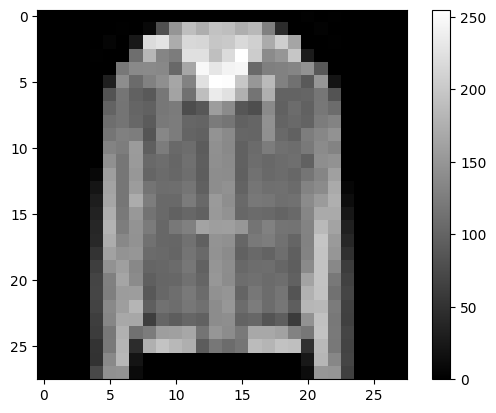

In [3]:
# 눈으로 이미지를 확인하기 위해 작성
i=28
plt.imshow(train_images[i], cmap="gray")
plt.colorbar()
print(train_labels[i])

In [4]:
# keras 데이터를 torch tensor로 변환
train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1) / 255.0  # (N, 1, 28, 28)
test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1) / 255.0
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [5]:
# 커스템 데이터셋 작성
class FashionTensorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [6]:
# transforms.Compose는 입력 데이터가 PIL.Image일 떄만 잘 작동
# 따라서 ToTensor를 먼저 사용해줘야함. 따라서 최신버전 사용

# 데이터 Augmentation
aug_transform = v2.Compose([
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3)),  # 렌덤으로 픽셀을 지운다
    v2.Lambda(lambda x: x + 0.01 * torch.randn_like(x)),  # 가우시안 노이즈 생성
    # v2.Normalize((0.3,), (0.4,))
    # v2.Normalize((0.2860,), (0.3530,))  # fashion Mnist의 mean과 std인데 결과가 좋지않아 0.5와 1.0으로 설정. 이와 같이 설정했을때 높은 accuracy가 나옴
    v2.Normalize((0.5,), (1.0,))  # valid acc 95.30 % v2.Normalize((0.5,), (1.0,))
])

test_transform = v2.Compose([
    # v2.Normalize((0.3,), (0.4,))
    # v2.Normalize((0.2860,), (0.3530,))
    v2.Normalize((0.5,), (1.0,))
])

In [7]:
# train_dataset을 생성
train_dataset = FashionTensorDataset(train_images, train_labels, transform=test_transform)

In [8]:
# train/valid 분리
train_idx, valid_idx = random_split(range(len(train_images)), [55_000, 5_000], generator=g)

# tarin_subset, valid_subset 생성
train_subset = FashionTensorDataset(train_images[train_idx.indices], train_labels[train_idx.indices], transform=test_transform)
valid_subset = FashionTensorDataset(train_images[valid_idx.indices], train_labels[valid_idx.indices], transform=test_transform)

In [9]:
# train_data만 증강하여 concat
augment_dataset = FashionTensorDataset(train_images[train_idx.indices], train_labels[train_idx.indices], transform=aug_transform)

# 일반 데이터와 변형된 데이터를 concat하여 학습데이터 증강
full_dataset = ConcatDataset([train_subset, augment_dataset])

In [10]:
# test Dataset 생성
test_dataset = FashionTensorDataset(test_images, test_labels, transform=test_transform)

In [11]:
# DataLoader 만들기
BATCH_SIZE = 1024 # 95.30 % 1024

train_DL = torch.utils.data.DataLoader(
    dataset=full_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True, num_workers=4
    )

valid_DL = torch.utils.data.DataLoader(
    dataset=valid_subset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4
    )

test_DL = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True
    )

In [12]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.same_channels = (in_channels == out_channels)

#         self.conv_block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.GELU(),
#             nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels)
#         )

#         if not self.same_channels:
#             self.skip_conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
#         else:
#             self.skip_conv = nn.Identity()

#     def forward(self, x):
#         identity = self.skip_conv(x)
#         out = self.conv_block(x)
#         out += identity
#         out = F.gelu(out)
#         return out

# class MyResNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.feature_extractor = nn.Sequential(
#             # 초기 특징 추출 (1→32)
#             ResidualBlock(1, 32),        # Conv 2층
#             ResidualBlock(32, 32),       # Conv 4층
#             nn.AvgPool2d(2),             # 28x28 → 14x14

#             # 중간 레벨 특징 (32→64)
#             ResidualBlock(32, 64),       # Conv 6층
#             ResidualBlock(64, 64),       # Conv 8층
#             nn.AvgPool2d(2),             # 14x14 → 7x7

#             # 고수준 특징 (64→128)
#             ResidualBlock(64, 128),      # Conv 10층
#             nn.AvgPool2d(2),             # 7x7 → 4x4

#             # 출력 특징 강화 (128→256)
#             ResidualBlock(128, 256)      # Conv 12층
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(256 * 3 * 3, 512),
#             nn.BatchNorm1d(512),
#             nn.GELU(),
#             nn.Dropout(0.2),

#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.GELU(),
#             nn.Dropout(0.2),

#             nn.Linear(256, 10)
#         )

#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = self.classifier(x)
#         return x


# ResNet18도 사용해보고 일반 conv모델도 사용해보았다
# 위 둘중에는 ResNet18의 정확도가 더 좋았으나 데이터셋에 비해 모델이 너무깊어 학습이 잘 안되었다
# 따라서 깊이를 줄인 잔차학습 기법을 사용하여 정확도를 향상 시켰다다
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = (in_channels == out_channels)

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        if not self.same_channels:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.skip_conv = nn.Identity()

    def forward(self, x):
        identity = self.skip_conv(x)
        out = self.conv_block(x)
        out += identity
        out = F.gelu(out)
        return out


class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            ResidualBlock(1, 32),
            ResidualBlock(32, 32),
            nn.MaxPool2d(2),            # 28→14

            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2),            # 14→7

            ResidualBlock(64, 128),
            nn.AvgPool2d(2),            # 7→4

            ResidualBlock(128, 256)     # 4×4 유지
        )

        # ☆ 여기서 ResNet18 방식 적용 (GAP)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # (256, 1, 1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.global_pool(x)   # ★ GAP 적용
        x = self.classifier(x)
        return x



# # 모델 정의(3층짜리 conv)
# class MyModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # CNN 부분 (특징 추출)
#         self.feature_extractor = nn.Sequential(
#             nn.Conv2d(1, 32, 3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.GELU(),
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.GELU(),
#             nn.AvgPool2d(2),

#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.GELU(),
#             nn.AvgPool2d(2),
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128*7*7, 256),
#             nn.BatchNorm1d(256),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 10)
#         )

#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = self.classifier(x)
#         return x

# class ResNet18(nn.Module):
#     def __init__(self, pretrained=False):
#         super().__init__()
#         # 1. 기본 ResNet18 불러오기
#         self.model = models.resnet18(pretrained=pretrained)

#         # 2. 입력층 (1채널 grayscale 이미지용으로 수정)
#         self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

#         # 3. FashionMNIST는 28×28이라 maxpool 제거
#         self.model.maxpool = nn.Identity()

#         # 4. 출력층 변경 (10 classes)
#         self.model.fc = nn.Linear(self.model.fc.in_features, 10)

#     def forward(self, x):
#         return self.model(x)


# class ResNet18(nn.Module):
#     def __init__(self, pretrained=False):
#         super().__init__()
#         #  기본 ResNet18 로드
#         base = models.resnet18(pretrained=pretrained)

#         # 입력층 수정 (grayscale → 1채널)
#         base.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

#         # 작은 입력 크기용 maxpool 제거
#         base.maxpool = nn.Identity()

#         # feature extractor만 사용 (fc 제외)
#         self.feature_extractor = nn.Sequential(*list(base.children())[:-2])  # 마지막 avgpool 전까지

#         # 분류기: 기존 MyModel의 classifier 재사용
#         self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1, 1)),   # MyModel의 Linear 입력 크기(128*7*7)에 맞추기
#             nn.Flatten(),
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 10)
#         )

#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = self.classifier(x)
#         return x


## 5층짜리 conv
# class MyModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # CNN 부분 (특징 추출)
#         self.feature_extractor = nn.Sequential(
#             # 1 → 32
#             nn.Conv2d(1, 32, 3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.GELU(),

#             # 32 → 64
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.GELU(),
#             nn.AvgPool2d(2),  # 28 → 14

#             # 64 → 128
#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.GELU(),
#             nn.AvgPool2d(2),  # 14 → 7

#             # 128 → 256
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.GELU(),

#             # 256 → 512
#             nn.Conv2d(256, 512, 3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.GELU(),
#             nn.AvgPool2d(2),  # 7 → 3
#         )

#         # FC 입력 크기 계산: 512 * 3 * 3
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512 * 3 * 3, 256),
#             nn.BatchNorm1d(256),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 10)
#         )

#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = self.classifier(x)
#         return x


In [13]:
# # 모델 학습

LR = 0.00205 # 94.80 % 0.00205
EPOCH = 75 # 94.80 % 55
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# wandb설정을 위한 init과 변수 설정정
import wandb
wandb.init(project="fashion-mnist-resnet",
           name="MyResNet_Run",
           mode="offline")


# wandb에 하이퍼파라미터 기록 (선택)
wandb.config.update({
    "batch_size": BATCH_SIZE,
    "learning_rate": LR,
    "epochs": EPOCH,
    "optimizer": "AdamW",
    "scheduler": "CosineAnnealingLR",
    "model": "MyResNet",
})


def Train(model, train_DL, valid_DL, criterion, optimizer, scheduler, patience=30):
    loss_history = []
    NoT = len(train_DL.dataset)

    best_val_acc = 0.0
    trigger_times = 0
    best_model_state = None

    for ep in range(EPOCH):
        model.train()
        rloss = 0
        train_correct = 0
        train_total = 0

        # -------------------------
        #   🔵 Training Loop
        # -------------------------
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            rloss += loss.item() * x_batch.size(0)

            _, predicted = y_hat.max(1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()

        train_loss = rloss / NoT
        train_acc = train_correct / train_total * 100
        loss_history.append(train_loss)

        # -------------------------
        #   🔵 Validation Loop
        # -------------------------
        val_loss, val_acc = Evaluate(model, valid_DL, criterion)

        # 🔵 Scheduler
        scheduler.step()

        print(f"Epoch {ep+1}/{EPOCH} | Train loss: {train_loss:.3f} | "
              f"Val loss: {val_loss:.3f} | Train acc: {train_acc:.2f}% | Val acc: {val_acc:.2f}%")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # -------------------------
        #   🔵 WandB Logging!!
        # -------------------------
        wandb.log({
            "train_loss": train_loss,
            "valid_loss": val_loss,
            "train_accuracy": train_acc,
            "valid_accuracy": val_acc,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        # -------------------------
        #     🔵 Early Stopping
        # -------------------------
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            trigger_times = 0
            best_model_state = model.state_dict()
            print(f"→ Validation accuracy improved ({best_val_acc:.2f}%). Best model updated.")
        else:
            trigger_times += 1
            print(f"→ No improvement. Trigger times: {trigger_times}/{patience}")

            if trigger_times >= patience:
                print("Early stopping triggered.")
                break

        print("-" * 40)

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored model to best validation accuracy state ({best_val_acc:.2f}%).")

    return loss_history, best_model_state


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [14]:
# 모델 검증
def Evaluate(model, valid_DL, criterion):
    model.eval()  # 평가 모드 전환 (dropout, batchnorm 등 비활성화)
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():  # 검증 시에는 gradient 계산 불필요
        for x_batch, y_batch in valid_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            val_loss += loss.item() * x_batch.size(0)

            # 예측 결과
            _, predicted = torch.max(y_hat, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_loss = val_loss / len(valid_DL.dataset)
    acc = correct / total * 100
    return avg_loss, acc


In [15]:
# 모델 학습하기
model = MyResNet().to(DEVICE) # x_batch, y_batch, model 까지 DEVICE에 올려줘야 함 ResNet18(pretrained=False)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# 코사인 스케줄러를 사용하여 점차 LR을 줄여나가면서 학습이 잘되게 함
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH)
loss_history, best_model_state = Train(model, train_DL, valid_DL, criterion, optimizer, scheduler)

# plt.plot(range(1, len(loss_history) + 1), loss_history)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title("Train Loss (with Early Stopping)")
# plt.grid()
# plt.show()

Epoch 1/75 | Train loss: 0.938 | Val loss: 0.722 | Train acc: 80.51% | Val acc: 90.22%
LR: 0.002049
→ Validation accuracy improved (90.22%). Best model updated.
----------------------------------------
Epoch 2/75 | Train loss: 0.724 | Val loss: 0.709 | Train acc: 90.27% | Val acc: 90.52%
LR: 0.002046
→ Validation accuracy improved (90.52%). Best model updated.
----------------------------------------
Epoch 3/75 | Train loss: 0.688 | Val loss: 0.670 | Train acc: 91.81% | Val acc: 92.14%
LR: 0.002042
→ Validation accuracy improved (92.14%). Best model updated.
----------------------------------------
Epoch 4/75 | Train loss: 0.663 | Val loss: 0.663 | Train acc: 92.96% | Val acc: 92.48%
LR: 0.002036
→ Validation accuracy improved (92.48%). Best model updated.
----------------------------------------
Epoch 5/75 | Train loss: 0.648 | Val loss: 0.654 | Train acc: 93.66% | Val acc: 93.14%
LR: 0.002028
→ Validation accuracy improved (93.14%). Best model updated.
-------------------------------

In [16]:
# 학습 종료 후 평가
train_loss, train_acc = Evaluate(model, train_DL, criterion)
valid_loss, valid_acc = Evaluate(model, valid_DL, criterion)

print(f"최종 Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%")
print(f"최종 Valid Loss: {valid_loss:.3f}, Valid Accuracy: {valid_acc:.2f}%")

최종 Train Loss: 0.510, Train Accuracy: 99.60%
최종 Valid Loss: 0.631, Valid Accuracy: 95.48%


## 모델 저장

In [17]:
torch.save(best_model_state, "/kaggle/working/best_model.pth")
print("best_model_state saved as best_model.pt")

best_model_state saved as best_model.pt


## 테스트 데이터 평가

In [18]:
model = MyResNet().to(DEVICE)
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model.eval()  # 평가 모드 전환 (Dropout, BatchNorm 고정)
print("Best model successfully loaded!")


Best model successfully loaded!


In [19]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
test_loss, test_acc = Evaluate(model, test_DL, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.6393 | Test Accuracy: 95.19%


## 학습 결과 이미지 및 레이블 출력

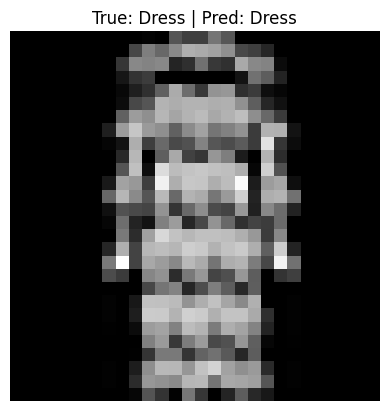

Correct prediction
--------------------------------------------------


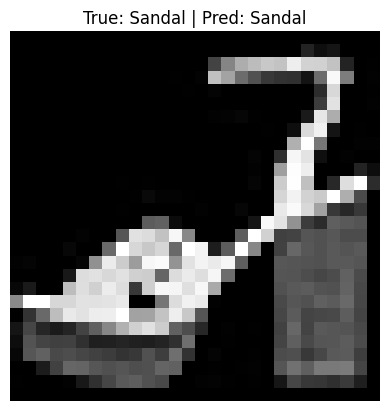

Correct prediction
--------------------------------------------------


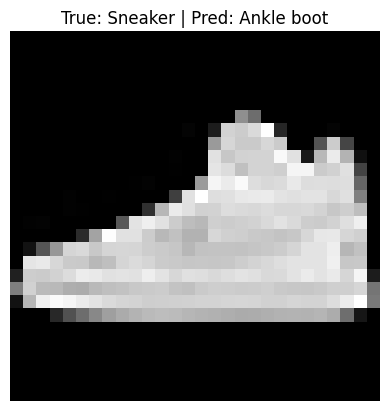

Wrong prediction
--------------------------------------------------


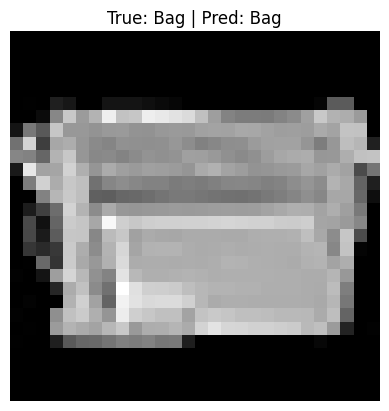

Correct prediction
--------------------------------------------------


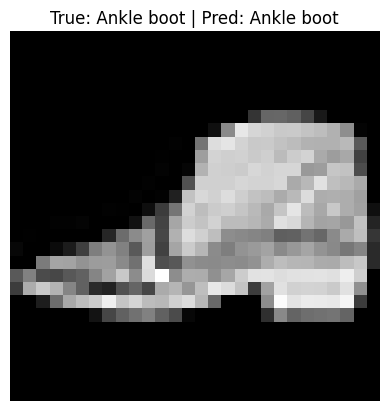

Correct prediction
--------------------------------------------------


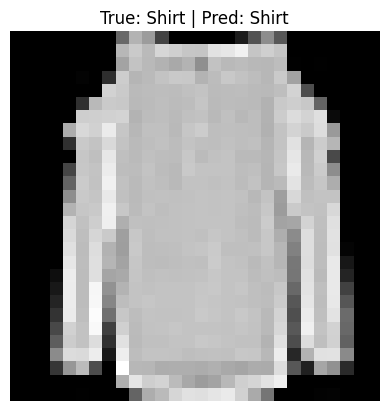

Correct prediction
--------------------------------------------------


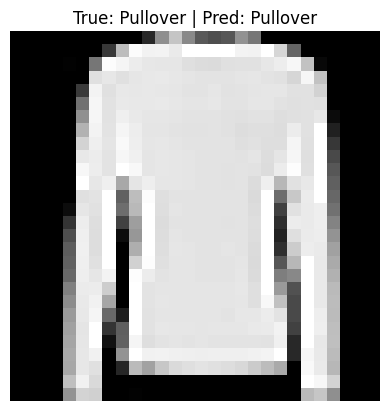

Correct prediction
--------------------------------------------------


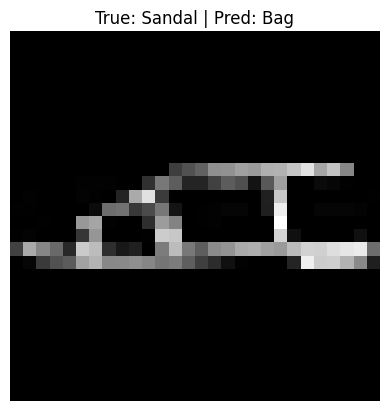

Wrong prediction
--------------------------------------------------


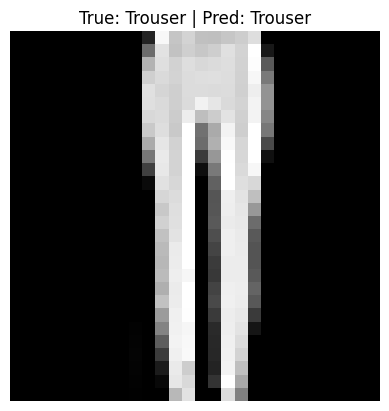

Correct prediction
--------------------------------------------------


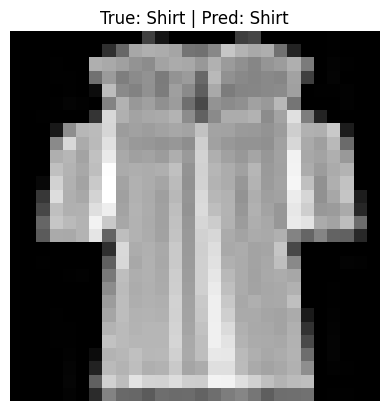

Correct prediction
--------------------------------------------------
총 2개의 오답 케이스가 탐지되었습니다.


In [20]:
import random
import matplotlib.pyplot as plt
import torch

# FashionMNIST 라벨 이름
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


# 10개 랜덤 테스트 샘플 출력 코드
def show_random_test_samples(model, test_images, test_labels, num_samples=10):
    model.eval()

    indices = random.sample(range(len(test_images)), num_samples)

    wrong_cases = []  # 오답 케이스 저장

    for idx in indices:
        img = test_images[idx]      # (1,28,28)
        label = test_labels[idx]

        # 모델 입력 형태로 변환
        x = img.unsqueeze(0).to(DEVICE)  # (1,1,28,28)

        with torch.no_grad():
            pred = model(x)
            pred_label = pred.argmax(1).item()

        # ★ 오답 케이스 저장
        if pred_label != label.item():
            wrong_cases.append((img, label.item(), pred_label))

        # 이미지 출력
        plt.imshow(img.squeeze(0).cpu(), cmap="gray")
        plt.title(f"True: {class_names[label.item()]} | Pred: {class_names[pred_label]}")
        plt.axis("off")
        plt.show()

        # 정답 여부 출력
        if pred_label == label.item():
            print("Correct prediction")
        else:
            print("Wrong prediction")

        print("-" * 50)

    return wrong_cases



# Tensor 형태의 test_images, test_labels가 있다고 가정
wrong_cases = show_random_test_samples(model, test_images, test_labels)

print(f"총 {len(wrong_cases)}개의 오답 케이스가 탐지되었습니다.")


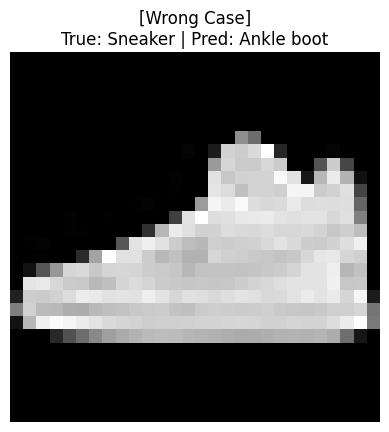

=== 오답 해석 ===
이 이미지는 실제로 'Sneaker'이지만,
모델은 'Ankle boot'로 잘못 예측했습니다.

가능한 이유:
- 이미지가 흐릿하거나 배경 노이즈 영향
- 옷의 형태가 두 클래스 간에 비슷하게 생김
- Augmentation으로 인해 비슷한 패턴을 다른 클래스로 학습했을 가능성
- 모델이 해당 클래스의 특징을 충분히 학습하지 못했을 수 있음


In [21]:
# 최소 1개의 오답 이미지 해석
if len(wrong_cases) > 0:
    img, true_label, pred_label = wrong_cases[0]

    plt.imshow(img.squeeze(0).cpu(), cmap="gray")
    plt.title(
        f"[Wrong Case]\nTrue: {class_names[true_label]} | Pred: {class_names[pred_label]}"
    )
    plt.axis("off")
    plt.show()

    print("=== 오답 해석 ===")
    print(f"이 이미지는 실제로 '{class_names[true_label]}'이지만,")
    print(f"모델은 '{class_names[pred_label]}'로 잘못 예측했습니다.\n")

    print("가능한 이유:")
    print("- 이미지가 흐릿하거나 배경 노이즈 영향")
    print("- 옷의 형태가 두 클래스 간에 비슷하게 생김")
    print("- Augmentation으로 인해 비슷한 패턴을 다른 클래스로 학습했을 가능성")
    print("- 모델이 해당 클래스의 특징을 충분히 학습하지 못했을 수 있음")
else:
    print("오답이 없습니다! (모델 정확도가 매우 높습니다.)")


## 숙제후기

이번 숙제는 딥러닝 모델의 정확도를 끌어 올려볼 모든 방안을 다 적용해본거같다.
수업시간에 배운 모든 방법을 다적용했을때는 오히려 성능이 많이 안좋아지는걸 확인했다.
fashion Mnist는 classification 중에는 단순한 데이터 셋이다.
하지만 오히려 더 많은 전처리 및 복잡한 모델을 사용하면 오히려 학습이 안좋게 된다.
대표적으로 나는 전처리 과정에서 많은 accuracy를 경험하였다.
처음에 5가지를 적용해보았고 1가지도 적용을 해보았었는데 3%이상 차이가 나는것을 확인했다.
검증을 해가며 최종적으로는 3가지의 전처리만 사용하여 진행했을때 매우 좋은 accuracy가 나오는것을 확인했다.
이번 데이터 셋에는
v2.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3)),  # 렌덤으로 픽셀을 지운다 
v2.Lambda(lambda x: x + 0.01 * torch.randn_like(x)),  # 가우시안 노이즈 생성
이 전처리가 매우 잘 맞았다고 생각한다 28x28의 이미지에서 한 픽셀마다의 의존도는 높아진다.
따라서 픽셀 지우기와 노이즈가 과적합을 예방하는데 탁월한 효과를 주었다고 생각한다.
이번 과제를 하며 전체적인 딥러닝 구현방법을 확실하게 알았다.
케글을 통해 다른 대회를 진행하며 확실하게 실력을 쌓아야겠다